In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
train_path = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
test_path = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

batch_size = 16
val_batch_size = 8

image_size = 224

## ResNet50

In [3]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=val_batch_size,
                                           shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [4]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [5]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(Dense(128, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(256, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(5, activation="softmax"))

model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 128)         262272    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 256)         33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [7]:
model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_resnet50 = model_resnet50.fit(train_batches, 
                                      validation_data=test_batches, 
                                      epochs=30, 
                                      verbose=1, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/30
380/380 [==============================] - 73s 163ms/step - loss: 0.7778 - acc: 0.6908 - val_loss: 0.3270 - val_acc: 0.8666
Epoch 2/30
380/380 [==============================] - 33s 86ms/step - loss: 0.3267 - acc: 0.8755 - val_loss: 0.2670 - val_acc: 0.8880
Epoch 3/30
380/380 [==============================] - 33s 86ms/step - loss: 0.1984 - acc: 0.9301 - val_loss: 0.1877 - val_acc: 0.9338
Epoch 4/30
380/380 [==============================] - 33s 86ms/step - loss: 0.1273 - acc: 0.9548 - val_loss: 0.1640 - val_acc: 0.9379
Epoch 5/30
380/380 [==============================] - 33s 87ms/step - loss: 0.0869 - acc: 0.9724 - val_loss: 0.1372 - val_acc: 0.9511
Epoch 6/30
380/380 [==============================] - 33s 86ms/step - loss: 0.0587 - acc: 0.9812 - val_loss: 0.1364 - val_acc: 0.9521
Epoch 7/30
380/380 [==============================] - 33s 87ms/step - loss: 0.0442 - acc: 0.9880 - val_loss: 0.1604 - val_acc: 0.9420
Epoch 8/30
380/380 [==============================] - 33s 87m

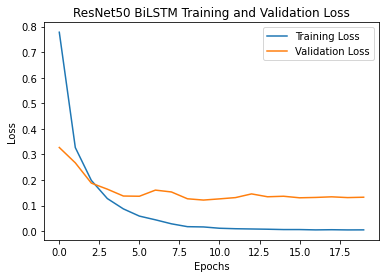

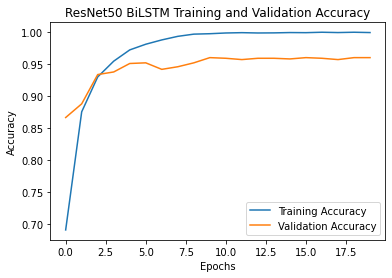

In [8]:
# Plot loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet50.history['acc'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 45ms/step - loss: 0.1214 - acc: 0.9603


In [10]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 46ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.96535   0.94660   0.95588       206
            covid19    0.96244   0.97156   0.96698       211
             normal    0.98030   0.95215   0.96602       209
       tuberculosis    0.97887   0.99286   0.98582       140
    viral_pneumonia    0.92342   0.94907   0.93607       216

           accuracy                        0.96029       982
          macro avg    0.96208   0.96245   0.96215       982
       weighted avg    0.96061   0.96029   0.96033       982



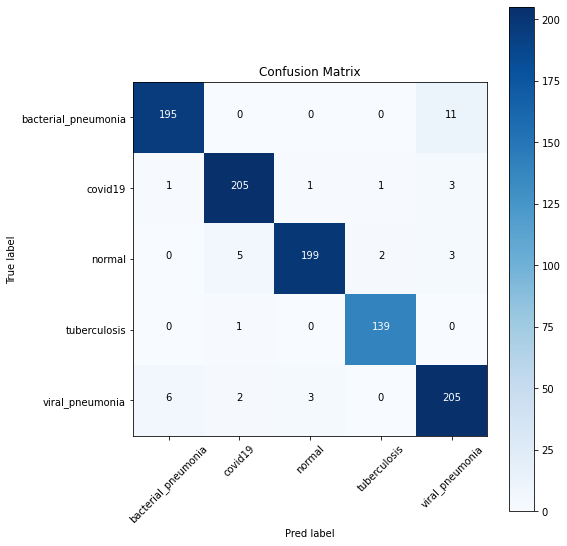

In [11]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [12]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 29s 76ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    1.00000   1.00000   1.00000      1220
            covid19    1.00000   1.00000   1.00000      1243
             normal    1.00000   1.00000   1.00000      1235
       tuberculosis    1.00000   1.00000   1.00000      1170
    viral_pneumonia    1.00000   1.00000   1.00000      1212

           accuracy                        1.00000      6080
          macro avg    1.00000   1.00000   1.00000      6080
       weighted avg    1.00000   1.00000   1.00000      6080



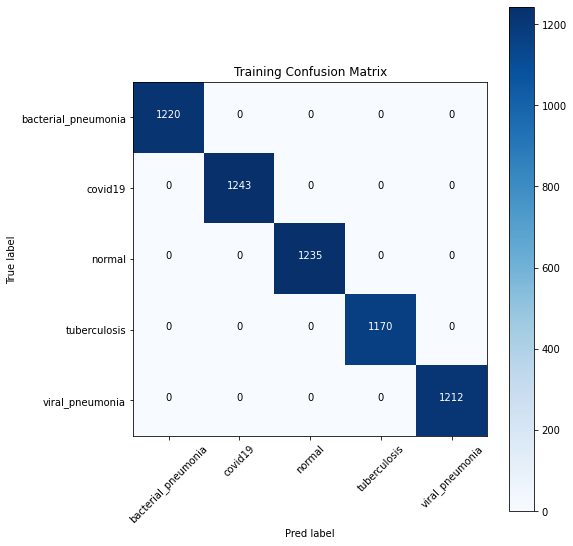

In [13]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [14]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [15]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [16]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(Dense(128, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(256, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Flatten())
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dense_3 (Dense)              (None, 7, 7, 128)         65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 7, 7, 256)         33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [17]:
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_vgg19 = model_vgg19.fit(train_batches, 
                                validation_data=test_batches, 
                                epochs=30, 
                                verbose=1, 
                                callbacks=[early_stopping, 
                                           reduce_lr])

Epoch 1/30
380/380 [==============================] - 46s 110ms/step - loss: 4.3594 - acc: 0.2725 - val_loss: 2.2155 - val_acc: 0.4236
Epoch 2/30
380/380 [==============================] - 38s 99ms/step - loss: 3.5700 - acc: 0.3410 - val_loss: 1.8591 - val_acc: 0.4684
Epoch 3/30
380/380 [==============================] - 38s 99ms/step - loss: 3.3272 - acc: 0.3720 - val_loss: 1.6630 - val_acc: 0.5163
Epoch 4/30
380/380 [==============================] - 38s 99ms/step - loss: 2.9831 - acc: 0.4072 - val_loss: 1.5209 - val_acc: 0.5499
Epoch 5/30
380/380 [==============================] - 38s 100ms/step - loss: 2.8646 - acc: 0.4280 - val_loss: 1.4033 - val_acc: 0.5733
Epoch 6/30
380/380 [==============================] - 38s 99ms/step - loss: 2.6770 - acc: 0.4437 - val_loss: 1.3107 - val_acc: 0.5988
Epoch 7/30
380/380 [==============================] - 38s 99ms/step - loss: 2.5165 - acc: 0.4773 - val_loss: 1.2442 - val_acc: 0.6232
Epoch 8/30
380/380 [==============================] - 38s 99

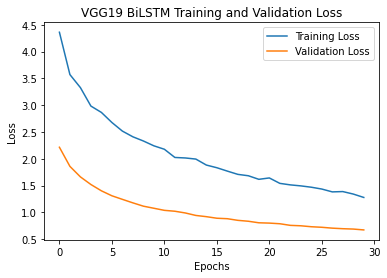

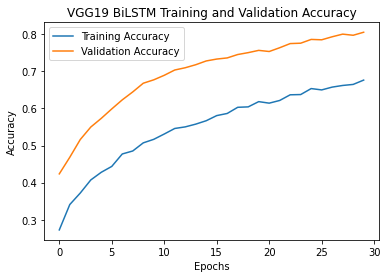

In [18]:
# Plot loss
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_vgg19.history['acc'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

123/123 [==============================] - 8s 63ms/step - loss: 0.6745 - acc: 0.8055


In [20]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 8s 62ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.73364   0.76214   0.74762       206
            covid19    0.85787   0.80095   0.82843       211
             normal    0.85047   0.87081   0.86052       209
       tuberculosis    0.85315   0.87143   0.86219       140
    viral_pneumonia    0.75234   0.74537   0.74884       216

           accuracy                        0.80550       982
          macro avg    0.80949   0.81014   0.80952       982
       weighted avg    0.80635   0.80550   0.80561       982



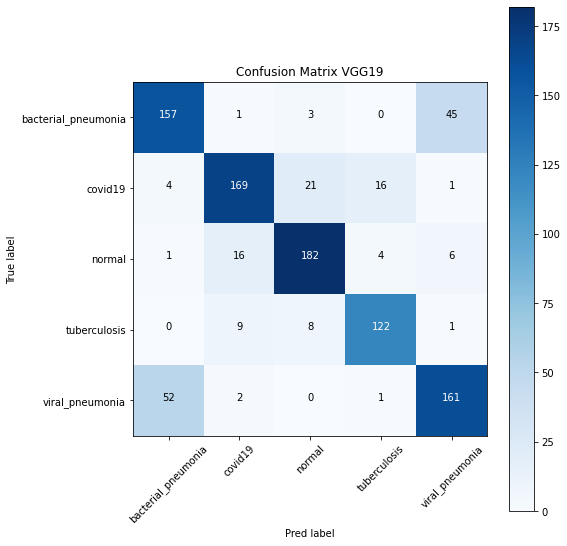

In [21]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [22]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 33s 87ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.77598   0.74672   0.76107      1220
            covid19    0.80919   0.73693   0.77137      1243
             normal    0.74944   0.81619   0.78140      1235
       tuberculosis    0.82684   0.81624   0.82151      1170
    viral_pneumonia    0.74254   0.78053   0.76106      1212

           accuracy                        0.77895      6080
          macro avg    0.78080   0.77932   0.77928      6080
       weighted avg    0.78050   0.77895   0.77893      6080



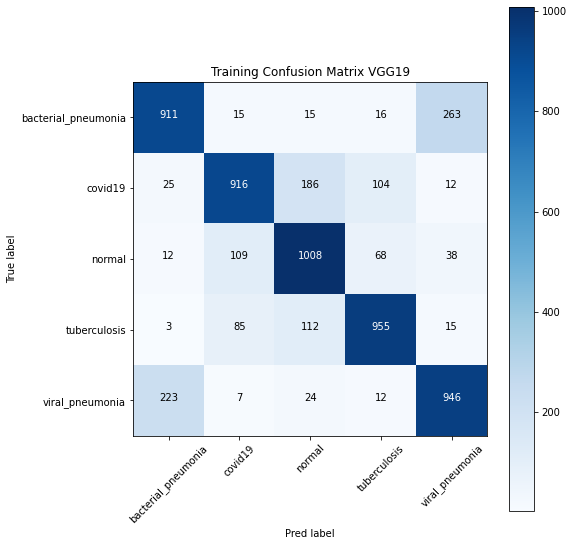

In [23]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [24]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [25]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [26]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(Dense(128, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(256, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dense_6 (Dense)              (None, 5, 5, 128)         262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
dense_7 (Dense)              (None, 5, 5, 256)         33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [27]:
model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_inceptionv3 = model_inceptionv3.fit(train_batches, 
                                            validation_data=test_batches, 
                                            epochs=30, 
                                            verbose=1, 
                                            callbacks=[early_stopping, 
                                                       reduce_lr])

Epoch 1/30
380/380 [==============================] - 38s 88ms/step - loss: 1.5886 - acc: 0.3112 - val_loss: 1.2668 - val_acc: 0.4847
Epoch 2/30
380/380 [==============================] - 31s 81ms/step - loss: 1.3667 - acc: 0.4140 - val_loss: 1.1361 - val_acc: 0.5438
Epoch 3/30
380/380 [==============================] - 30s 79ms/step - loss: 1.2773 - acc: 0.4572 - val_loss: 1.0551 - val_acc: 0.5815
Epoch 4/30
380/380 [==============================] - 30s 80ms/step - loss: 1.1946 - acc: 0.4947 - val_loss: 0.9952 - val_acc: 0.6110
Epoch 5/30
380/380 [==============================] - 30s 79ms/step - loss: 1.1420 - acc: 0.5211 - val_loss: 0.9491 - val_acc: 0.6253
Epoch 6/30
380/380 [==============================] - 31s 80ms/step - loss: 1.0910 - acc: 0.5444 - val_loss: 0.9123 - val_acc: 0.6446
Epoch 7/30
380/380 [==============================] - 30s 79ms/step - loss: 1.0574 - acc: 0.5656 - val_loss: 0.8790 - val_acc: 0.6487
Epoch 8/30
380/380 [==============================] - 31s 82ms

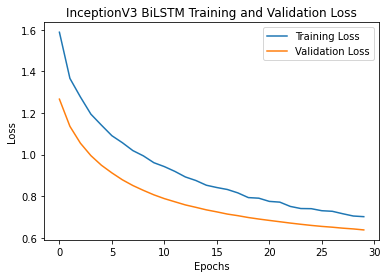

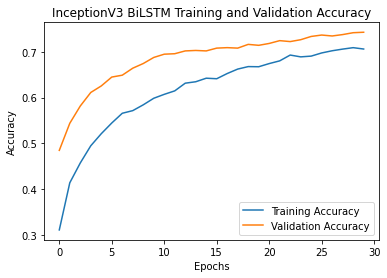

In [28]:
# Plot loss
plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_inceptionv3.history['acc'], label='Training Accuracy')
plt.plot(history_inceptionv3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

123/123 [==============================] - 5s 44ms/step - loss: 0.6381 - acc: 0.7424


In [30]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 6s 43ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.68844   0.66505   0.67654       206
            covid19    0.77778   0.82938   0.80275       211
             normal    0.74654   0.77512   0.76056       209
       tuberculosis    0.91071   0.72857   0.80952       140
    viral_pneumonia    0.66812   0.70833   0.68764       216

           accuracy                        0.74236       982
          macro avg    0.75832   0.74129   0.74740       982
       weighted avg    0.74722   0.74236   0.74294       982



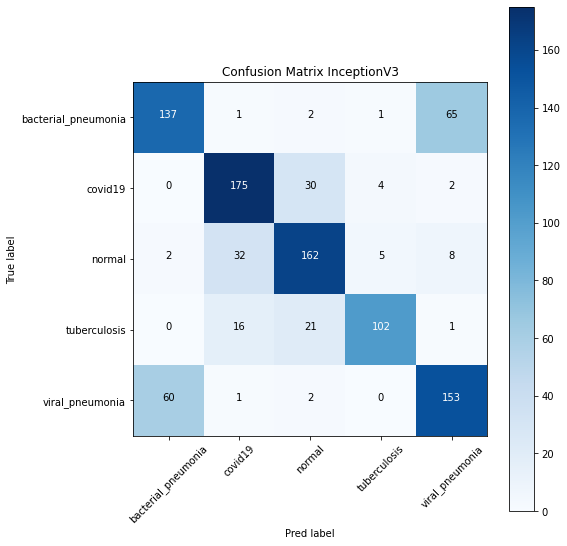

In [31]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [32]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 25s 65ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.70152   0.68197   0.69160      1220
            covid19    0.80944   0.78600   0.79755      1243
             normal    0.73258   0.78300   0.75695      1235
       tuberculosis    0.85175   0.81026   0.83049      1170
    viral_pneumonia    0.68660   0.71040   0.69830      1212

           accuracy                        0.75411      6080
          macro avg    0.75638   0.75432   0.75498      6080
       weighted avg    0.75583   0.75411   0.75460      6080



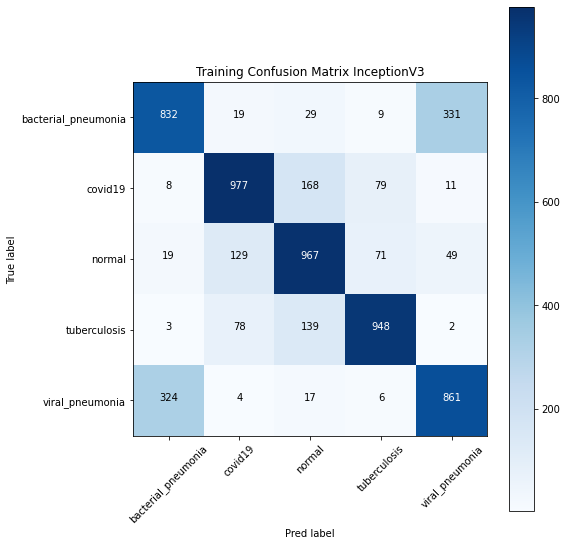

In [33]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()